### Лабораторная работа №4: Деревья решений 
##### Выполнил студент группы: 6131-010402D Павлов Владислав

### 1. Загрузка датасета

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

In [2]:
df = pd.read_csv("big_dataset.csv")

### 2.1 Описание датасета 

#### Большой набор данных о мошенничестве с онлайн-платежами
#### Цель - определить тип транзакции мошенническая или обычная

| Признак | Описание | Единицы измерения |
|:-------:|:--------:|:-----------------:|
| step | Шаг | numerical |
| type | Тип онлайн-транзакции | categorical |
| amount | Сумма транзакции | numerical |
| nameOrig | Клиент, запускающий транзакцию | categorical |
| oldbalanceOrg | Баланс до транзакции | numerical |
| newbalanceOrig | Баланс после транзакции | numerical | 
| nameDest | Получатель транзакции | categorical |
| oldbalanceDest | Баланс получателя до транзакции | numerical |
| newbalanceDest | Баланс получателя после транзакции | numerical |
| isFraud | Мошенническая транзакция  | binary |
| isFlaggedFraud | Флаг транзакции | binary |

##### Целевой класс содержит два значения - 0 или 1, где 0 - обычная транзакция, 1 - мошенническая транзакция



In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Так как датасет очень большой, возьму от исходного 1/80 часть 

In [5]:
df_length = len(df)
part = df_length // 80

part_df = df.sample(n = part)
print(part_df)

         step      type     amount     nameOrig  oldbalanceOrg  \
2057282   181  CASH_OUT  102815.69   C167161257           0.00   
4146208   303   CASH_IN   82563.43  C2024004473     3198558.70   
2719891   211  CASH_OUT   92009.34  C1280721533      131339.10   
1465986   140   PAYMENT   22483.30  C1297363558           0.00   
569443     23   PAYMENT   22532.18  C1568694960        5924.00   
...       ...       ...        ...          ...            ...   
2974426   231  CASH_OUT  234845.63  C1086048816       50638.00   
3878953   283  CASH_OUT  304379.46  C1126144504       20602.00   
4451301   323   PAYMENT    1669.96  C1016672133           0.00   
2671793   210   CASH_IN   58652.47   C808751103     7919136.73   
3355334   254  TRANSFER  292455.74   C920323736           0.00   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
2057282            0.00  C1383905614       892926.80       995742.49        0   
4146208      3281122.12  C1865742741       55

### 2.2 Предобработка данных

In [6]:
part_df.isna().any().any()

False

In [7]:
# Проверка на наличие null
part_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
columns_drop = ["step","nameOrig","nameDest", "isFlaggedFraud"]
df_dropped = part_df.drop(columns = columns_drop, axis= 1)


### 2.3 Кодировка категориальных признаков

In [9]:
unique_values = df_dropped["type"].unique()
print(unique_values)

['CASH_OUT' 'CASH_IN' 'PAYMENT' 'TRANSFER' 'DEBIT']


In [44]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_dropped["type"] = label_encoder.fit_transform(df_dropped["type"])
print(df_dropped["type"].head())


2057282    1
4146208    0
2719891    1
1465986    3
569443     3
Name: type, dtype: int64


### 2.4 Нормализация данных

In [11]:
x = df_dropped.drop("isFraud", axis = 1)
y = df_dropped["isFraud"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns = x.columns)

In [12]:
x_scaled_df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,-0.531507,-0.130897,-0.286368,-0.290153,-0.064752,-0.066407
1,-1.271819,-0.165110,0.836385,0.847266,-0.165845,-0.211898
2,-0.531507,-0.149153,-0.240265,-0.276519,0.174020,0.151579
3,0.949117,-0.266608,-0.286368,-0.290153,-0.334923,-0.345277
4,0.949117,-0.266526,-0.284288,-0.290153,-0.334923,-0.345277


### 2.5 Разбивка выборки на обучающую и тестовую

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

### 3. Дерево решений
#### 3.1 С использованием GridSearchCV осуществить подбор гиперпараметра DesicionTreeClassifier

In [14]:
grid = {
    'max_depth': range(1, x.shape[1]),
    'max_features': range(2, 20),
    'min_samples_leaf': range(5, 20)
}

model = DecisionTreeClassifier()

search = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose = 2)
search.fit(x_train, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6), 'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)},
             verbose=2)

### 3.2 Вывести значение гиперпараметра и метрик для наилучшей модели DecisionTreeClassifier

In [15]:
search.best_params_

{'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 12}

In [16]:
best_model = search.best_estimator_
best_model_pred = best_model.predict(x_train)

In [17]:
tree_model_acc = accuracy_score(y_train, best_model_pred)
tree_model_prec = precision_score(y_train, best_model_pred)
tree_model_rec = recall_score(y_train, best_model_pred)
tree_model_f1 = f1_score(y_train, best_model_pred)

print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")

Accuracy: 0.6999030033050726; Precision: 0.8333333333333334; Recall: 0.0005982650314089142; F1_score: 0.0011956716685598136


### 3.3 Для получения наилучшего дерева вывести feature_importances, отсортировать по убыванию


In [18]:

feature_importances = best_model.feature_importances_

feature_importance_dict = {feature: importance for feature, importance in zip(x_train.columns, feature_importances)}

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Отсортированные значения feature_importances по убыванию:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Отсортированные значения feature_importances по убыванию:
newbalanceOrig: 0.4800082452834834
newbalanceDest: 0.30063983611451844
oldbalanceDest: 0.11519147595438688
oldbalanceOrg: 0.10416044264761135
type: 0.0
amount: 0.0


### 3.4 Осуществить фильтрацию признаков 

In [19]:
threshold = np.mean([value for _, value in sorted_feature_importance])
selected_features = [feature for feature, value in sorted_feature_importance if value > threshold]
selected_features

['newbalanceOrig', 'newbalanceDest']

### 3.5 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками 

In [20]:
x_train_filtered = x_train[selected_features]
# x_train_filtered.head()

search_filtered = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose= 2)
search_filtered.fit(x_train_filtered, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6), 'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)},
             verbose=2)

### 3.6 Вывести полученные гиперпараметры лучшей модели

In [21]:
search_filtered.best_params_

{'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 5}

### 3.7 Сравнить метрики до и после фильтрации признаков лучших моделей

In [22]:
best_model_filtered = search_filtered.best_estimator_
best_model_filtered_pred = best_model_filtered.predict(x_train_filtered)

In [23]:
tree_model_filtered_acc = accuracy_score(y_train, best_model_filtered_pred)
tree_model_filtered_prec = precision_score(y_train, best_model_filtered_pred)
tree_model_filtered_rec = recall_score(y_train, best_model_filtered_pred)
tree_model_filtered_f1 = f1_score(y_train, best_model_filtered_pred)

print("Before:")
print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")

print("After:")
print(f"Accuracy: {tree_model_filtered_acc}; Precision: {tree_model_filtered_prec}; Recall: {tree_model_filtered_rec}; F1_score: {tree_model_filtered_f1}")

Before:
Accuracy: 0.6999030033050726; Precision: 0.8333333333333334; Recall: 0.0005982650314089142; F1_score: 0.0011956716685598136
After:
Accuracy: 0.6998311539014226; Precision: 0.8333333333333334; Recall: 0.0002991325157044571; F1_score: 0.0005980503558399617


#### После фильтрации признаков, значение метрик ухудшилось, но не значительно 

### 4. Случайный лес
#### 4.1 Построить случайный лес (Random Forest Classifier), с использованием GridSearchCV осуществить подбор гиперпараметра

In [24]:
forest_model = RandomForestClassifier()

forest_grid = {
    'max_depth': range(1, x.shape[1]),
    'n_estimators': range(10, 160, 5)
}

forest_search = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose= 2)
forest_search.fit(x_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(10, 160, 5)},
             verbose=2)

### 4.2 Вывести полученные гиперпараметры лучшей модели случайного леса

In [25]:
forest_search.best_params_

{'max_depth': 5, 'n_estimators': 35}

### 4.3 Осуществить фильтрацию признаков

In [26]:
forest_best_model = forest_search.best_estimator_

In [27]:
forest_feature_importances = forest_best_model.feature_importances_

forest_feature_importance_dict = {feature: importance for feature, importance in zip(x_train.columns, forest_feature_importances)}

forest_sorted_feature_importance = sorted(forest_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Отсортированные значения feature_importances по убыванию:")
for feature, importance in forest_sorted_feature_importance:
    print(f"{feature}: {importance}")


Отсортированные значения feature_importances по убыванию:
amount: 0.2984849586757474
oldbalanceOrg: 0.20483063299984433
newbalanceDest: 0.19747714233616465
oldbalanceDest: 0.14773518658240256
newbalanceOrig: 0.13386204929426246
type: 0.017610030111578627


In [28]:
forest_threshold = np.mean([value for _, value in forest_sorted_feature_importance])
forest_selected_features = [feature for feature, value in forest_sorted_feature_importance if value > forest_threshold]
forest_selected_features

['amount', 'oldbalanceOrg', 'newbalanceDest']

### 4.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [29]:
x_train_forest_filtered = x_train[forest_selected_features]
x_train_forest_filtered.head()

,amount,oldbalanceOrg,newbalanceDest
3021920,6642.73,70754.00,171281.03
6176519,32449.85,446146.26,0.00
34204,9306.22,311439.15,0.00
1552212,40246.34,1850796.49,1373347.38
6144582,485893.68,611.00,485893.68


In [30]:
forest_search_filtered = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose= 2)
forest_search_filtered.fit(x_train_forest_filtered, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(10, 160, 5)},
             verbose=2)

### 4.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [31]:
forest_search_filtered.best_params_

{'max_depth': 5, 'n_estimators': 65}

### 4.6 Сравнить метрики до и после фильтрации признаков лучших моделей.

In [32]:
forest_best_model_filtered = forest_search_filtered.best_estimator_

In [33]:
forest_model_predict = forest_best_model.predict(x_train)
forest_model_filtered_prediict = forest_best_model_filtered.predict(x_train_forest_filtered)

forest_model_acc = accuracy_score(y_train, forest_model_predict)
forest_model_prec = precision_score(y_train, forest_model_predict)
forest_model_rec = recall_score(y_train, forest_model_predict)
forest_model_f1 = f1_score(y_train, forest_model_predict)

forest_model_filtered_acc = accuracy_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_prec = precision_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_rec = recall_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_f1 = f1_score(y_train, forest_model_filtered_prediict)


print("Before:")
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")

print("After:")
print(f"Accuracy: {forest_model_filtered_acc}; Precision: {forest_model_filtered_prec}; Recall: {forest_model_filtered_rec}; F1_score: {forest_model_filtered_f1}")

Before:
Accuracy: 0.7002263256214973; Precision: 0.9642857142857143; Recall: 0.0016153155848040682; F1_score: 0.003225228453682136
After:
Accuracy: 0.7000826268141974; Precision: 1.0; Recall: 0.0010768770565360455; F1_score: 0.002151437279627084


#### Можно сказать, что метрики незначительно ухудшились

### 5. Метод ближайших соседей
#### 5.1 С использованием GridSearchCV осуществить подбор гиперпараметра KNeighborsClassifier (n_neighbors).

In [34]:
knn_model = KNeighborsClassifier()

In [35]:
knn_grid = {'n_neighbors': range(2, 50)}

knn_search = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs=-1, verbose=2)
knn_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 5.2 Вывести значения гиперпараметра и метрик для наилучшей модели.

In [36]:
knn_search.best_params_

{'n_neighbors': 48}

### 5.3 Осуществить фильтрацию признаков.

In [37]:
knn_filtered = forest_selected_features
x_train_knn_filtered = x_train[knn_filtered]
x_train_knn_filtered.head()

,amount,oldbalanceOrg,newbalanceDest
3021920,6642.73,70754.00,171281.03
6176519,32449.85,446146.26,0.00
34204,9306.22,311439.15,0.00
1552212,40246.34,1850796.49,1373347.38
6144582,485893.68,611.00,485893.68


### 5.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [38]:
knn_search_filtered = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs= -1, verbose= 2)
knn_search_filtered.fit(x_train_knn_filtered, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 5.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [39]:
knn_search_filtered.best_params_

{'n_neighbors': 48}

### 5.6 Сравнить метрики до и после фильтрации признаков.

In [40]:
knn_best_model = knn_search.best_estimator_
knn_best_model_filtered = knn_search_filtered.best_estimator_

In [41]:
knn_model_predict = knn_best_model.predict(x_train)
knn_model_filtered_prediict = knn_best_model_filtered.predict(x_train_knn_filtered)

knn_model_acc = accuracy_score(y_train, knn_model_predict)
knn_model_prec = precision_score(y_train, knn_model_predict)
knn_model_rec = recall_score(y_train, knn_model_predict)
knn_model_f1 = f1_score(y_train, knn_model_predict)

knn_model_filtered_acc = accuracy_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_prec = precision_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_rec = recall_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_f1 = f1_score(y_train, knn_model_filtered_prediict)


print("Before:")
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

print("After:")
print(f"Accuracy: {knn_model_filtered_acc}; Precision: {knn_model_filtered_prec}; Recall: {knn_model_filtered_rec}; F1_score: {knn_model_filtered_f1}")

Before:
Accuracy: 0.7002622503233223; Precision: 0.6372549019607843; Recall: 0.003888722704157942; F1_score: 0.007730272938098353
After:
Accuracy: 0.6999389280068975; Precision: 0.5641025641025641; Recall: 0.002632366138199222; F1_score: 0.005240278687548383


### 6. Если наблюдается улучшение метрик после фильтрации признаков хотя бы для одной из моделей, то для набора отфильтрованных признаков заново построить наилучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, сравнить модели в пункте 7 на одинаковом полученном наборе отфильтрованных признаков. Иначе – пропустить этот пункт.

#### Улучшений замечено не было

### 7. Оценка качества построенных моделей
#### 7.1 Визуализировать любое полученное дерево решений.

[Text(0.5, 0.875, 'newbalanceOrig <= 11711951.5\ngini = 0.42\nsamples = 55672\nvalue = [38957, 16715]\nclass = Secondary'),
 Text(0.25, 0.625, 'newbalanceDest <= 4170277.625\ngini = 0.42\nsamples = 54782\nvalue = [38370, 16412]\nclass = Secondary'),
 Text(0.125, 0.375, 'newbalanceDest <= 3910403.5\ngini = 0.419\nsamples = 50807\nvalue = [35657.0, 15150.0]\nclass = Secondary'),
 Text(0.0625, 0.125, 'gini = 0.419\nsamples = 50452\nvalue = [35383, 15069]\nclass = Secondary'),
 Text(0.1875, 0.125, 'gini = 0.352\nsamples = 355\nvalue = [274, 81]\nclass = Secondary'),
 Text(0.375, 0.375, 'oldbalanceDest <= 3186844.625\ngini = 0.433\nsamples = 3975\nvalue = [2713, 1262]\nclass = Secondary'),
 Text(0.3125, 0.125, 'gini = 0.481\nsamples = 159\nvalue = [95, 64]\nclass = Secondary'),
 Text(0.4375, 0.125, 'gini = 0.431\nsamples = 3816\nvalue = [2618, 1198]\nclass = Secondary'),
 Text(0.75, 0.625, 'oldbalanceOrg <= 12370629.5\ngini = 0.449\nsamples = 890\nvalue = [587, 303]\nclass = Secondary'),
 T

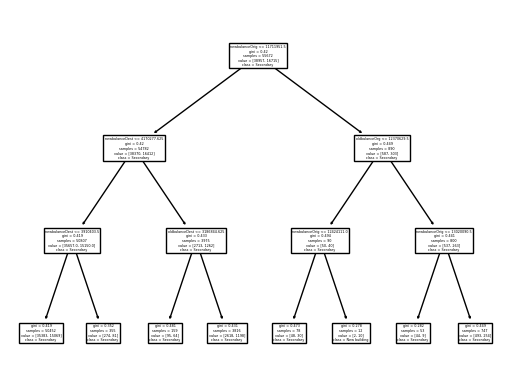

In [42]:
plot_tree(decision_tree=best_model, feature_names=x_train.columns, class_names=['Secondary','New building'])

### 7.2 Сравнить лучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier на тестовой выборке. Привести значения метрик.

In [43]:
best_model_pred = best_model.predict(x_test)
forest_model_predict = forest_best_model.predict(x_test)
knn_model_predict = knn_best_model.predict(x_test)


tree_model_acc = accuracy_score(y_test, best_model_pred)
tree_model_prec = precision_score(y_test, best_model_pred)
tree_model_rec = recall_score(y_test, best_model_pred)
tree_model_f1 = f1_score(y_test, best_model_pred)

forest_model_acc = accuracy_score(y_test, forest_model_predict)
forest_model_prec = precision_score(y_test, forest_model_predict)
forest_model_rec = recall_score(y_test, forest_model_predict)
forest_model_f1 = f1_score(y_test, forest_model_predict)

knn_model_acc = accuracy_score(y_test, knn_model_predict)
knn_model_prec = precision_score(y_test, knn_model_predict)
knn_model_rec = recall_score(y_test, knn_model_predict)
knn_model_f1 = f1_score(y_test, knn_model_predict)


print('-----------DECISION TREE-----------')
print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")
print('-----------RANDOM FOREST-----------')
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")
print('-----------KNN-----------')
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

-----------DECISION TREE-----------
Accuracy: 0.7028080469404862; Precision: 0.16666666666666666; Recall: 0.00014110342881332017; F1_score: 0.00028196813760045117
-----------RANDOM FOREST-----------
Accuracy: 0.7031852472757754; Precision: 1.0; Recall: 0.0007055171440666008; F1_score: 0.0014100394811054709
-----------KNN-----------
Accuracy: 0.7023470243084661; Precision: 0.25806451612903225; Recall: 0.0011288274305065614; F1_score: 0.00224782242202866
